In [2]:
import os
import numpy as np
from pathlib import Path
from argparse import Namespace
from fastai2.vision.all import *

args = Namespace(
    root = "/".join(os.getcwd().split("/")[:-1]),
    bucket_name = "sagemaker-us-west-2-430127992102",
    key = "TiendaApp",
    image_dir = "fastai_data",
    data_dir = "input/data/training",
    tar_file_name = "fastai_data.tar.gz",
    model_dir = "model",
    model_fastai_dir = "fastai_model",
    tar_model_name = "fastai_model.tar.gz"
)

In [3]:
model_path = os.path.join(args.root, args.model_dir)
data_path = Path(os.path.join(args.root, args.data_dir))
os.listdir(data_path)

['yogurt_alpina_finesse_fresax180g',
 'coca_cola_originalx400ml',
 'coca_cola_originalx250ml',
 'arroz_basmati_castellanox1000g',
 'chicharron_americano_jacksx15g',
 'papas_limon_margaritax110g',
 'arroz_vitamor_dianax500g',
 '.DS_Store',
 'papas_limon_margaritax39g',
 'mango_tommy',
 'yogurt_alpina_finesse_fresax150g',
 'papas_limon_margaritax105g',
 'models',
 'yogurt_alpina_finesse_frutos_rojosx180g',
 'pan_mantequilla_la_fronterax55g',
 'papas_limon_margarita_packeconomicox300g',
 'maracuya',
 'aguacate',
 'yogurt_alpina_finesse_melocotonx180g',
 'spagheti_barilla',
 'arroz_blanco_carullax1000g',
 'pan_de_queso_la_frontera']

In [3]:
import fastai
import fastcore
fastai.__version__, fastcore.__version__

('2.0.0', '0.1.39')

In [5]:
data = ImageDataLoaders.from_folder(data_path, valid_pct=0.2, bs=8, item_tfms=Resize(224), 
                    batch_tfms=[*aug_transforms(),Normalize.from_stats(*imagenet_stats)], num_workers=0)

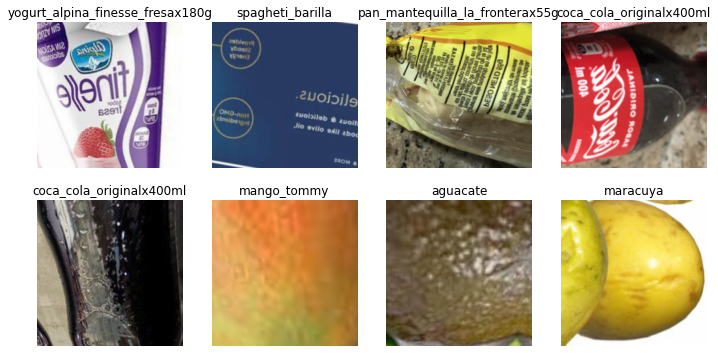

In [59]:
data.show_batch()

In [6]:
learn = cnn_learner(data, resnet34, metrics=[error_rate,accuracy])

In [65]:
learn.fit_one_cycle(3)

epoch,train_loss,valid_loss,error_rate,accuracy,time
0,1.043770,0.355140,0.126357,0.873643,36:05
1,0.667009,0.292854,0.097730,0.902270,35:50
2,0.532469,0.248594,0.099704,0.900296,35:46


In [66]:
learn.save(os.path.join(model_path,'stage-1'))

In [70]:
!ls ../model

stage-1.pth


In [71]:
learn.unfreeze()

SuggestedLRs(lr_min=7.585775892948732e-06, lr_steep=9.12010818865383e-07)

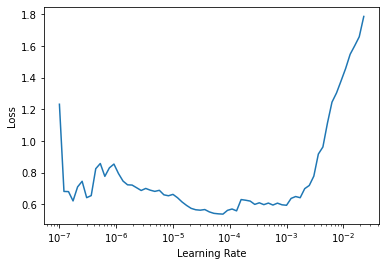

In [72]:
learn.lr_find()

In [76]:
learn.fit_one_cycle(2,max_lr=slice(3e-5,3e-3))

epoch,train_loss,valid_loss,error_rate,accuracy,time
0,1.968018,1.133583,0.381046,0.618954,49:21
1,1.129955,0.624139,0.217177,0.782823,49:09


In [9]:
learn.recorder.plot_loss()

AttributeError: 'Learner' object has no attribute 'plot'

In [7]:
learn.load(os.path.join(model_path, 'stage-1'))

In [77]:
learn.save(os.path.join(model_path, 'stage-2'))

FileNotFoundError: [Errno 2] No such file or directory: '/opt/ml/model/fastai_model/stage-2.pth'

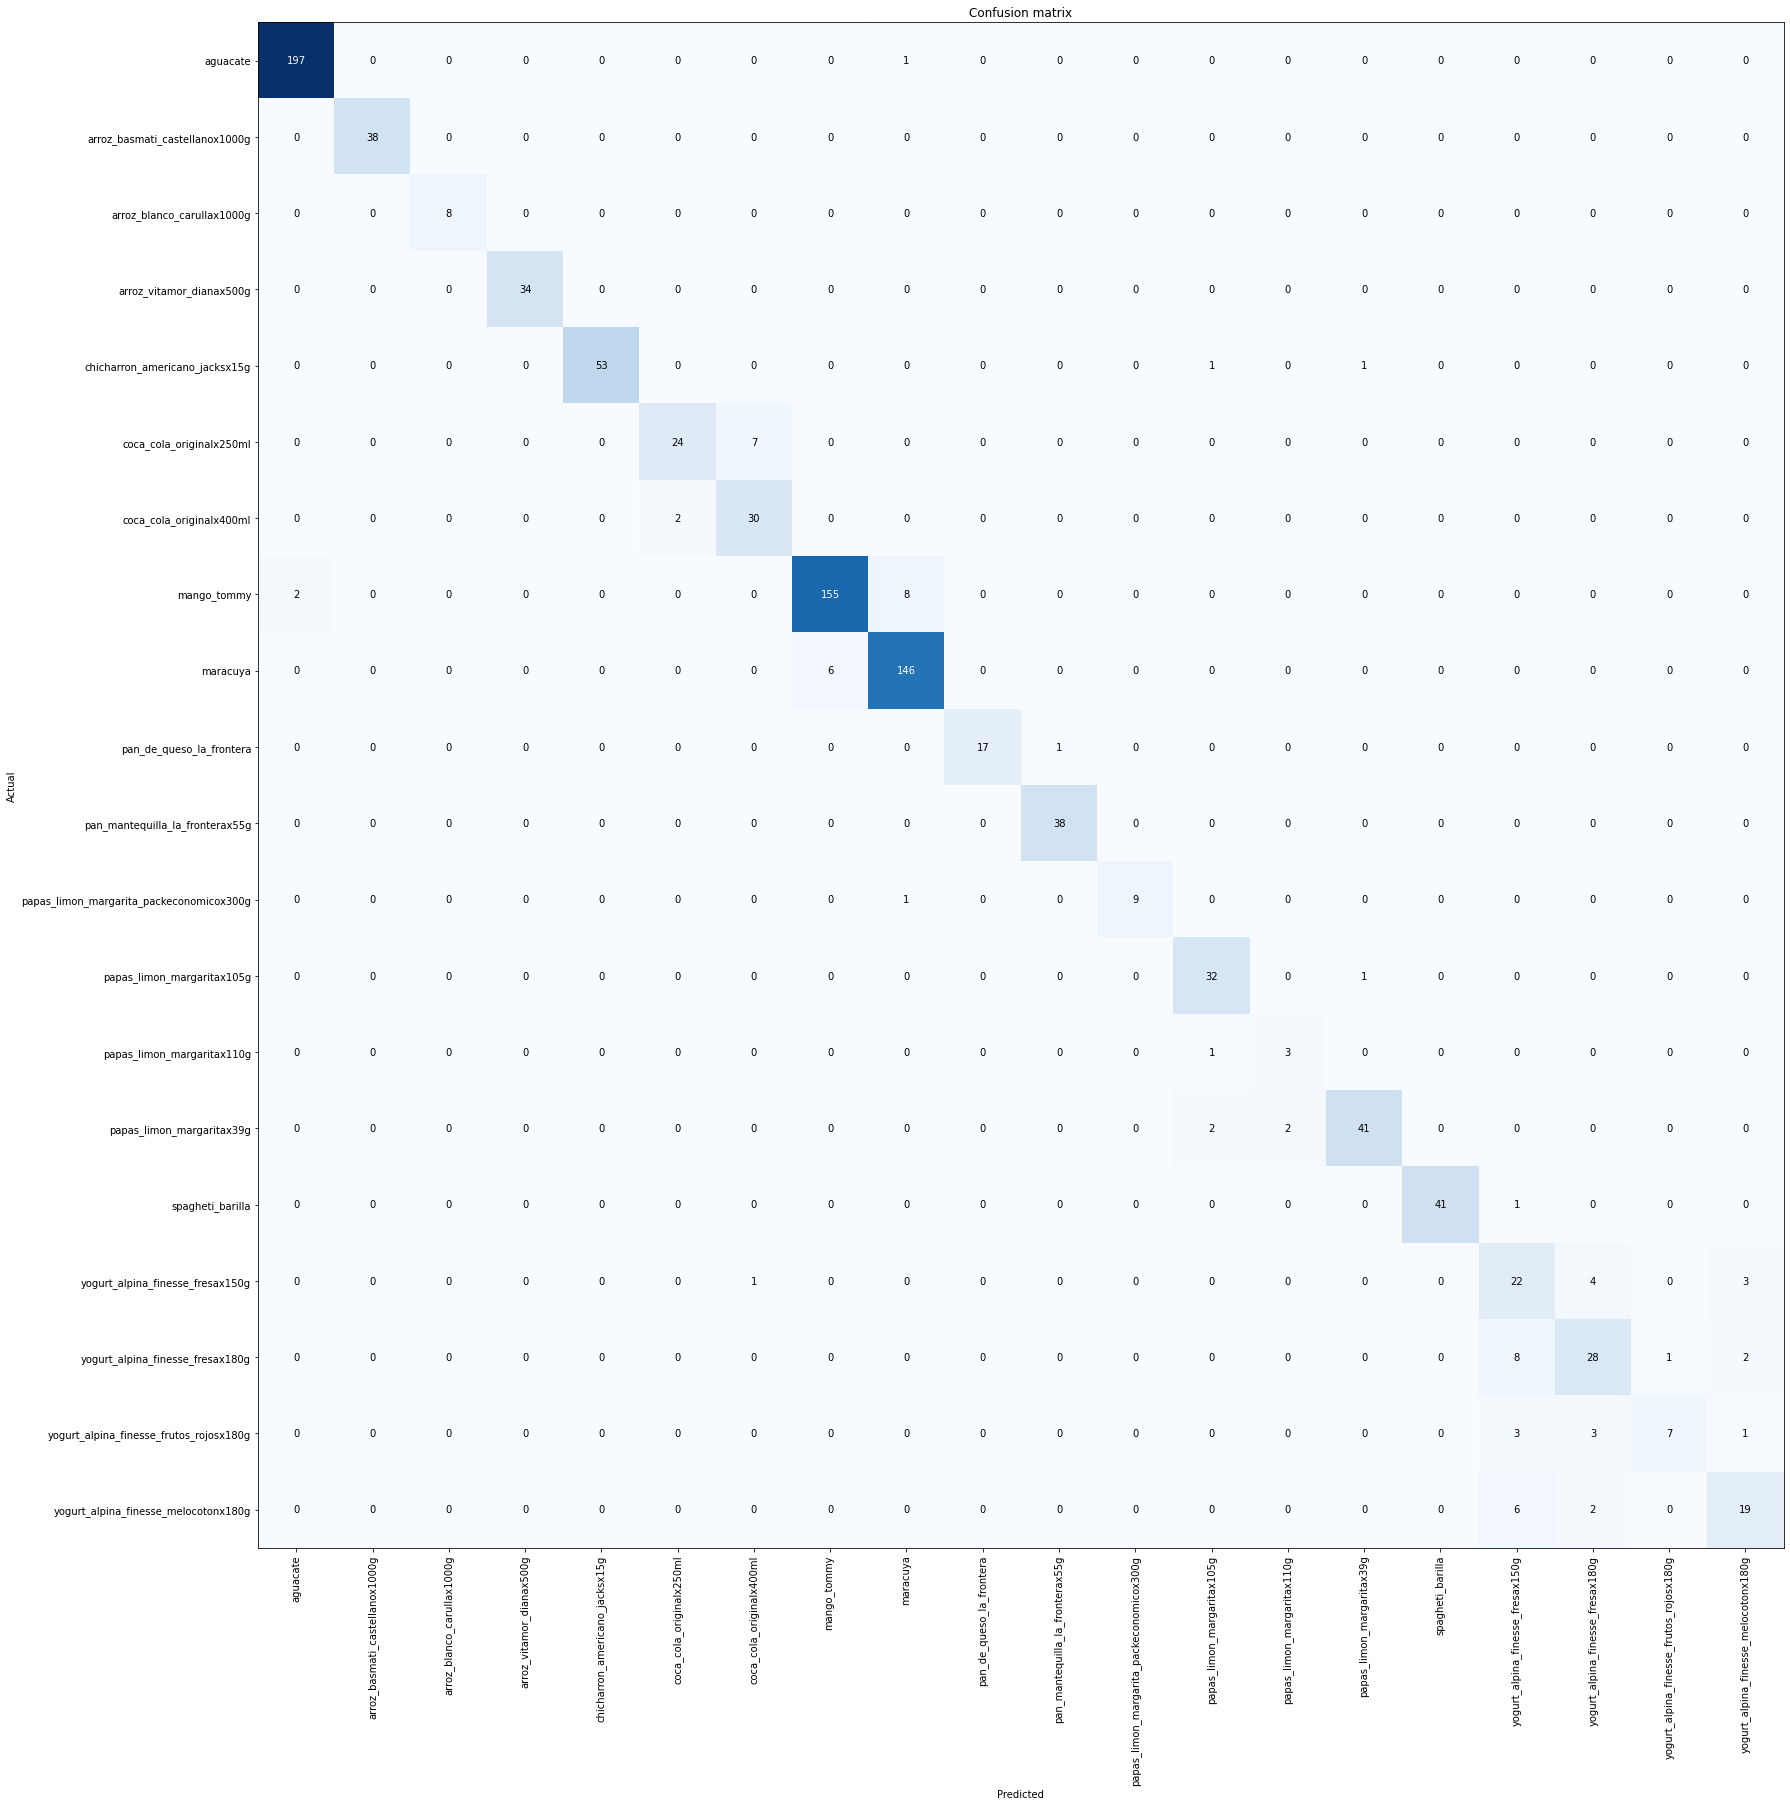

In [10]:
interp = ClassificationInterpretation.from_learner(learn)
interp.plot_confusion_matrix(figsize=(30,25))